# Load data

In [1]:
import numpy as np
import util
import core

raw_data = np.loadtxt('data/population_data.txt', delimiter = ',')
# After the transpose, each column is a year, each row is a population type
raw_data = raw_data.T
print(f'Hare min = {np.min(raw_data[0,:])}, max = {np.max(raw_data[0,:])}')
print(f'Lynx min = {np.min(raw_data[1,:])}, max = {np.max(raw_data[1,:])}')

Hare min = 7.0, max = 150.0
Lynx min = 6.0, max = 80.0


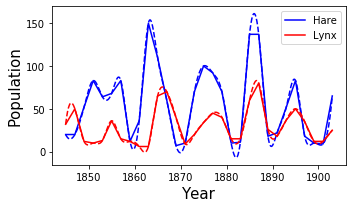

In [2]:
DPI = 120
IMG_PATH_PREFIX = 'writeup/images/'

data = util.get_interpolated_data(raw_data)
fig = util.compare_interpolation_with_data(raw_data, data)
fig.tight_layout()
fig.savefig(IMG_PATH_PREFIX + 'interpolated.png', format='png', dpi=DPI)
num_time_full = data.shape[1]
first_half_time = int(num_time_full/2)
# Models are trained only on the first half years
training_data = data[:, :first_half_time]

# Run DMD and predict

In [3]:
Phi, Lambda, b = core.dmd(training_data, r = 2)
dmd_pred = core.get_xt_from_dmd(num_time=num_time_full, Phi = Phi, Lambda = Lambda, b = b)
print(Lambda)

[[0.99917301+0.01336596j 0.        +0.j        ]
 [0.        +0.j         0.99917301-0.01336596j]]


Lambda is close to 1, and has a complex component. So, we will see oscillation.

# Visualize prediction against data

Hare L2 norm discrepancy = 1993.51 
Lynx L2 norm discrepancy = 944.97 


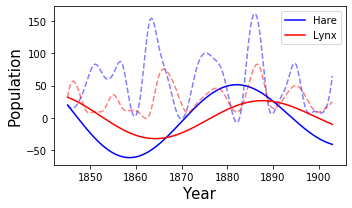

In [4]:
fig = util.compare_pred_with_data(data, dmd_pred)
fig.tight_layout()
fig.savefig(IMG_PATH_PREFIX + 'dmd.png', format='png', dpi=DPI)

There is oscillation alright, but the fit was poor. But! It's interesting that it captures the fact that hare should rise first before lynx.

# Sliding DMD

In [5]:
# Skipped. I'm just going to train on the first half, and predict second half so I can systemetically
# compare all the approaches.
# start_predict_time = first_half_time
# predictions = core.get_sliding_dmd_predictions(data, r = 2, start_predict_time = start_predict_time, dmd_window = 5)
# util.compare_pred_with_data(data[:, start_predict_time: ], predictions)

# Latent variables in time embedded data

Percent energy covered: [0.89410799 0.99657567 0.99937921 0.9999917  0.99999841 0.99999999
 1.         1.         1.         1.         1.         1.        ]


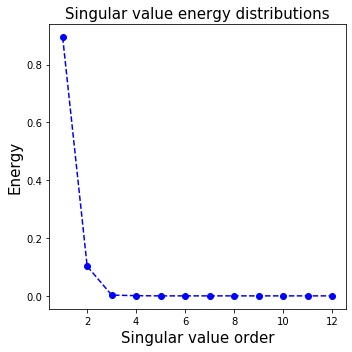

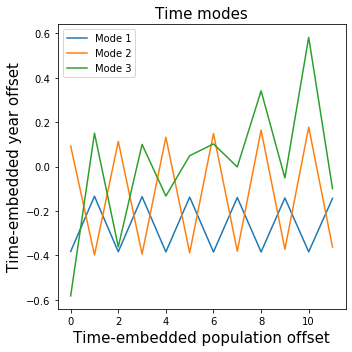

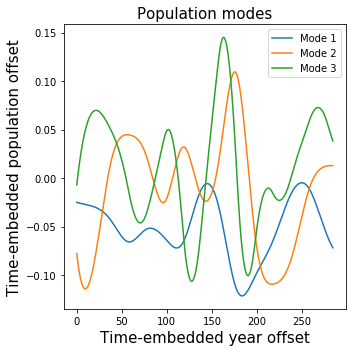

In [6]:
time_delayed_data = core.time_delay_embed(training_data, k = 6)
fig = core.plot_energy_from_singular_values(time_delayed_data)
fig.tight_layout()
fig.savefig(IMG_PATH_PREFIX + 'time_delayed_energy.png', format='png', dpi=DPI)
fig_pop_mode, fig_time_mode = core.plot_population_modes(time_delayed_data, 3)
fig_pop_mode.tight_layout()
fig_pop_mode.savefig(IMG_PATH_PREFIX + 'time_delayed_time_mode.png', format='png', dpi=DPI)
fig_time_mode.tight_layout()
fig_time_mode.savefig(IMG_PATH_PREFIX + 'time_delayed_population_mode.png', format='png', dpi=DPI)

The system seems to be at least 3 dimensions. That is, one would need at least 3 spatial bases (or as the question put it, latent variables) in order to capture the time-embedded data. If embedding is 6, would need 3 singular values to capture 90% of the energy.

Percent energy covered: [0.90393413 0.96776351 0.99371559 0.9986798  0.99978584 0.99997743
 0.99999511 0.99999917 0.99999977 0.99999991 0.99999997 0.99999998
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


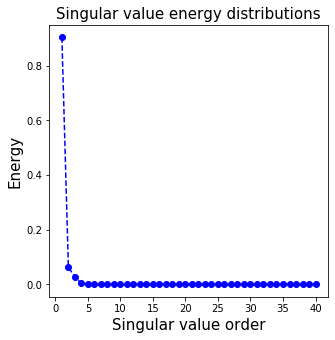

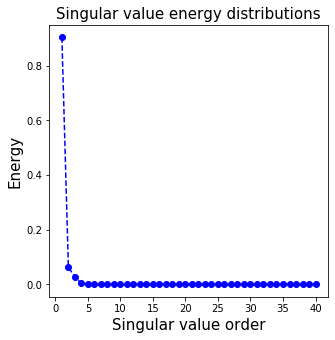

In [7]:
time_delayed_data_20 = core.time_delay_embed(data, k = 20)
core.plot_energy_from_singular_values(time_delayed_data_20)

# Time delay embedding

In [8]:
time_delayed_first_half_data = core.time_delay_embed(training_data, k = 6)
Phi, Lambda, b = core.dmd(time_delayed_first_half_data, r = 3)
pred_time_delayed_xt = core.get_xt_from_dmd(num_time=num_time_full, Phi = Phi, Lambda = Lambda, b = b)

In [9]:
Lambda.shape

(3, 3)

In [10]:
pred_time_delayed_xt.shape

(12, 581)

Hare L2 norm discrepancy = 970.10 
Lynx L2 norm discrepancy = 411.38 


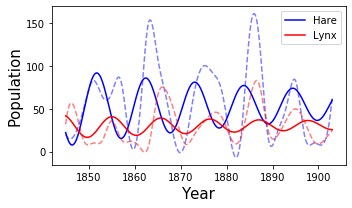

In [11]:
# Only take the first two rows to convert from time_delayed to normal time.
fig = util.compare_pred_with_data(data, pred_time_delayed_xt[:2,:])
fig.tight_layout()
fig.savefig(IMG_PATH_PREFIX + 'dmd_time_delay.png', format='png', dpi=DPI)

# Lotka volterra

b = 0.21653360081251793, p = 0.009022790896317268, r = 0.005989655439854101, d = 0.38127917794708316
Hare L2 norm discrepancy = 1139.85 
Lynx L2 norm discrepancy = 583.29 


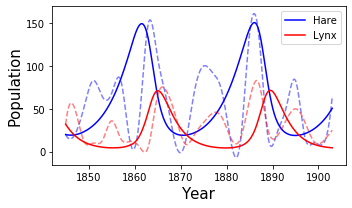

In [12]:
b,p,r,d = core.get_best_fit_lotka_volterra_params(training_data)
print(f"b = {b}, p = {p}, r = {r}, d = {d}")
lotka_volterra_predictions = core.generate_predictions_from_lotka_volterra(b, p, r, d)
fig = util.compare_pred_with_data(data, lotka_volterra_predictions)
fig.tight_layout()
fig.savefig(IMG_PATH_PREFIX + 'lotka.png', format='png', dpi=DPI)

# Sparse regression: Validate Lotka Volterra

Hare L2 norm discrepancy = 1139.85 
Lynx L2 norm discrepancy = 583.29 
dx/dt = 0.21653360081251793 x + -0.009022790896317268 xy
dy/dt = -0.38127917794708316 y + 0.005989655439854101 xy


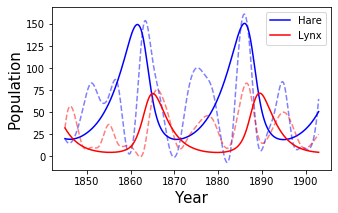

In [13]:
# As a validation, use the coefficients from Lotka Volterra
lv_dx_library_coefs = np.zeros(len(core.F_LIB_2))
lv_dy_library_coefs = np.zeros(len(core.F_LIB_2))
# bx
lv_dx_library_coefs[0] = b
# -pxy
lv_dx_library_coefs[3] = -p
# -dy
lv_dy_library_coefs[1] = -d
# rxy
lv_dy_library_coefs[3] = r
sindy_predictions = core.generate_predictions_from_sindy(
  lv_dx_library_coefs, lv_dy_library_coefs, core.F_LIB_2).y
util.compare_pred_with_data(data, sindy_predictions)
util.pretty_print_sindy_coefs(lv_dx_library_coefs, lv_dy_library_coefs, core.F_LIB_2)

# Sparse regression: Polynomials of degree 1, 2, 3

In [14]:
from sklearn import linear_model
def get_sindy_coefs_with_alpha(alpha, f_lib, should_plot = False):
  regression_model = linear_model.Lasso(alpha=alpha, max_iter=100000)
  dx_library_coefs, dy_library_coefs = core.get_sindy_params(
    training_data, regression_model, f_lib)
  
  if should_plot:
    fig = util.plot_sindy_coefs(dx_library_coefs, dy_library_coefs, f_lib)
    fig.suptitle(f"α = {alpha:.1f}", fontsize = 15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    fig.savefig(IMG_PATH_PREFIX + 'sindy_coef.png', format='png', dpi=DPI)
    util.pretty_print_sindy_coefs(dx_library_coefs, dy_library_coefs, f_lib)
  # We need the lotka volterra as low as 0.005. If we trim even that, even lotka volterra wouldn't work.
  # util.trim_sindy_coefs(dx_library_coefs, dy_library_coefs, coef_threshold = 0.001)
  sol = core.generate_predictions_from_sindy(dx_library_coefs, dy_library_coefs, f_lib)
  if should_plot:
    fig = util.compare_pred_with_data(data, sol.y)
    fig.tight_layout()
    fig.savefig(IMG_PATH_PREFIX + 'sindy_pred.png', format='png', dpi=DPI)
  return sol, dx_library_coefs, dy_library_coefs

In [15]:
def find_best_alpha(f_lib):
  # Find the best_alpha for f_lib, where best is defined by the smallest frobenius
  # norm of the discrepancies on the training set.
  alphas = np.arange(0.1, 10, 0.1)
  errors = np.zeros(len(alphas))
  # A default high value, because later we will take min
  max_error = 10000
  errors += max_error
  for i, alpha in enumerate(alphas):
    sol, dx_library_coefs, dy_library_coefs = get_sindy_coefs_with_alpha(alpha, f_lib, should_plot = False)
    if sol.success:
      error = util.score_population_pred(training_data, sol.y[:,:training_data.shape[1]])
      errors[i] = error
  if np.min(errors) == max_error:
    print("None of the solutions converged :(")
  else:
    lowest_err_idx = np.argmin(errors)
    sol, dx_library_coefs, dy_library_coefs =\
        get_sindy_coefs_with_alpha(alphas[lowest_err_idx], f_lib, should_plot = True)
    return sol.y, dx_library_coefs, dy_library_coefs

dx/dt = 0.02559439160879515 x + 0.0037677806877161554 x2 + -0.011436992297399404 xy + 0.013782293474617109 y2 + -9.850490624321755e-06 x3 + -0.00015207097558666402 x2y + 0.0004218062423637939 xy2 + -0.0004279316829573991 y3
dy/dt = -0.00024901201326920746 x2 + -0.00029684876763324603 xy + -0.004759480168695225 y2 + 4.9460216283046395e-06 x3 + 6.569998572080776e-05 x2y + -7.313234526525422e-05 xy2 + 7.780400768256714e-05 y3
Hare L2 norm discrepancy = 1055.48 
Lynx L2 norm discrepancy = 506.12 


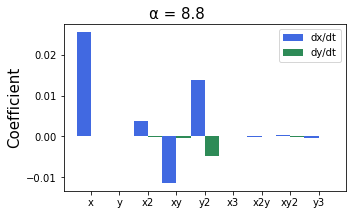

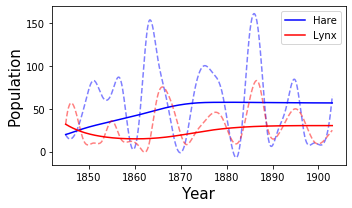

In [16]:
flib3_preds, dx_library_coefs_flib3, dy_library_coefs_flib3 = find_best_alpha(core.F_LIB_3)

dx/dt = 0.26328181642067516 x + -0.4837222031977832 y + -0.0007354616798030701 x2 + -0.00773398154516457 xy + 0.005107296581201789 y2
dy/dt = -0.06596303131532179 x + 0.0013348523825749165 x2 + 0.003645301240827776 xy + -0.0031406223352384533 y2
Hare L2 norm discrepancy = 4914.93 
Lynx L2 norm discrepancy = 739.04 


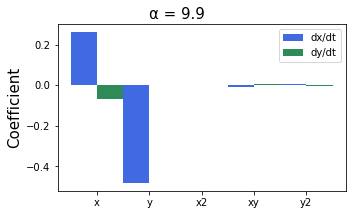

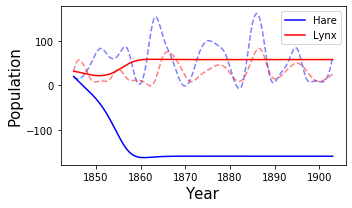

In [17]:
flib2_preds, dx_library_coefs_flib2, dy_library_coefs_flib2 = find_best_alpha(core.F_LIB_2)

dx/dt = -0.007894933449457336 x + -0.6112504165690882 y
dy/dt = 0.1861428755150967 x
Hare L2 norm discrepancy = 1961.74 
Lynx L2 norm discrepancy = 960.18 


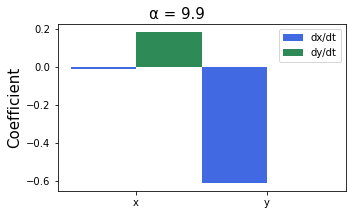

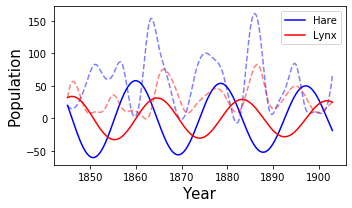

In [18]:
flib1_preds, _, _ = find_best_alpha(core.F_LIB_1)

In [19]:
import pdb
def extract_important_functions(f_lib, dx_library_coefs, dy_library_coefs, num_keep):
  """
  Given a function library, and the coefficients for dx/dt and dy/dt,
  create a sparser function library by capturing only the top 'num_keep' terms
  We do not simply trim these values to 0 because as seen in the Lotka Volterra
  example, even coefficients as small as 0.005 are very important, especially in capturing non-linearities.
  """
  max_coeff_amps = np.maximum(np.abs(dx_library_coefs), np.abs(dy_library_coefs))
  desc_order = np.argsort(-1 * max_coeff_amps)
  important_indices = set(desc_order[:num_keep])
  
  # Extract library functions that correspond to important indices.
  return [f for i, f in enumerate(f_lib) if i in important_indices]

In [20]:
# There are 9 in total, one of which is 0
trimmed_flib3 = extract_important_functions(core.F_LIB_3, dx_library_coefs_flib3, dy_library_coefs_flib3, 4)
trimmed_flib3

[('x', <function core.<lambda>(s)>),
 ('x2', <function core.<lambda>(s)>),
 ('xy', <function core.<lambda>(s)>),
 ('y2', <function core.<lambda>(s)>)]

dx/dt = 0.37684348957887537 x + -0.0012105096866583678 x2 + -0.008982900999409855 xy + -0.00014619441624797702 y2
dy/dt = -0.11497695088663461 x + 0.001610065569916969 x2 + 0.003957019229767708 xy + -0.0033826953220113913 y2
Hare L2 norm discrepancy = 1047.48 
Lynx L2 norm discrepancy = 492.69 


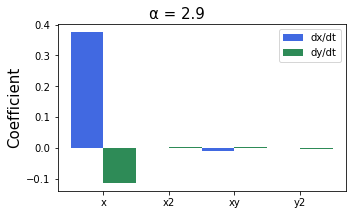

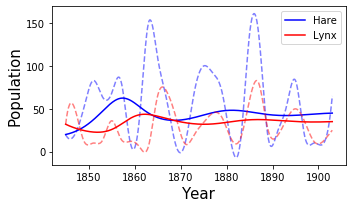

In [21]:
trimmed_flib3_preds,_,_ = find_best_alpha(trimmed_flib3)

# KL Divergence scores

In [22]:
test_data = data[:, first_half_time:]

In [23]:
gold_distribution = core.get_population_joint_distribution(test_data)

In [24]:
# Ignore DMD, Flib1, Flib2, which predicts negative population weights.
predictions = [
  #("DMD", dmd_pred),
  #("Flib1", flib1_preds),
  #("Flib2", flib2_preds),
  ("Time-delayed DMD", pred_time_delayed_xt),
  ("Lotka-Volterra", lotka_volterra_predictions),
  ("Flib3", flib3_preds),
  ("Flib3trimmed", trimmed_flib3_preds),
]

for model, prediction in predictions:
  pred_distribution = core.get_population_joint_distribution(prediction[:, first_half_time:])
  print(f'{model}: {core.get_kl_divergence(gold_distribution, pred_distribution)}')

Time-delayed DMD: 6.0388123986913484
Lotka-Volterra: 6.210575413787241
Flib3: 6.279477219126655
Flib3trimmed: 6.184432174688311


# AIC, BIC

In [25]:
top_3_models = [
  # 2 * 6 * 3 (Phi) + 3 (Lambda) parameters for time-delayed dmd, r = 3, embedding = 6.
  # 2 is because there is hare and lynx.
  ("Time-delayed DMD", pred_time_delayed_xt, 12 * 3 + 3),
  # 4 parameters: b,p,r,d
  ("Lotka-Volterra", lotka_volterra_predictions, 4),
  # We trimmed to 4 library functions
  ("Flib3trimmed", trimmed_flib3_preds, 8)
]

for model, prediction, k in top_3_models:
  # We compute AIC BIC on the same data we train against.
  aic, bic = core.get_aic_bic(k, training_data, prediction[:,:first_half_time])
  print(f"{model}: AIC:{aic}, BIC:{bic}")

Time-delayed DMD: AIC:7282.16168669316, BIC:7425.287042689401
Lotka-Volterra: AIC:7266.046429817145, BIC:7280.725953509067
Flib3trimmed: AIC:7324.924683787165, BIC:7354.283731171009


Lotka-Volterra seems to perform the best out of all the 3 models, according to both the AIC and BIC standards.